In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import numpy as np
from enum import Enum

import pandas_helper as ph
import constants as C

import mitigation_functions as mitifunc
import subs_analysis_functions

In [2]:
new_cell = (9.35, 50.02) # spessart region
south_cell = (11.28, 47.60)
bavarian_forest_cell = (13.50, 48.90)
center_cell = (11.74, 48.96)
north_cell = (11.69, 50.37)

forest_types = ['ne', 'bd']

agenames = {
    1930: 'mature',
    1990: 'young'
}

all_cells = [new_cell, south_cell, bavarian_forest_cell, center_cell, north_cell]

rcp_color_vals={ 'rcp26' : 'dodgerblue', 'rcp45': 'darkgreen', 'rcp85' : 'red' }

class DistIncrease(Enum):
    CONSTANT = 0
    LINEAR = 1
    EXP = 2

plt.style.use('seaborn')

In [3]:
# requires unpacking of the .tar.gz archive
data_path = 'lpjguess_outputs/'

# Model Evaluation

## Fluxes

In [4]:
npps = []
gpps = []
for forest in forest_types:
    for forest_plant_time in [1930, 1990]:
        for rcp in ['rcp26', 'rcp45', 'rcp85']:

            npp = ph.read_for_years(data_path + 'forest_' + forest + '_rcp_' + rcp + '_usage_100_residence_100_man_100_salvage_1_disturb_' + str(forest_plant_time) + '_increaseddist_1_newharv100patch_insdistfix/anpp.out', 2000, 2015, lons_lats_of_interest=all_cells).groupby(['Year']).mean()
            gpp = ph.read_for_years(data_path + 'forest_' + forest + '_rcp_' + rcp + '_usage_100_residence_100_man_100_salvage_1_disturb_' + str(forest_plant_time) + '_increaseddist_1_newharv100patch_insdistfix/agpp.out', 2000, 2015, lons_lats_of_interest=all_cells).groupby(['Year']).mean()

            npps.append(npp['Forest_sum'].mean())
            gpps.append(gpp['Forest_sum'].mean())

print('NPP', np.mean(npps), 'compared to 0.687 kgC/m2/yr, 2000-2015 GEE')
print('GPP', np.mean(gpps), 'compared to 1.444 kgC/m2/yr, 2001-2015 GOSIF')

NPP 0.7137322916666666 compared to 0.687 kgC/m2/yr, 2000-2015 GEE
GPP 1.49189375 compared to 1.444 kgC/m2/yr, 2001-2015 GOSIF


## Mitigation

In [5]:
importlib.reload(mitifunc)
importlib.reload(subs_analysis_functions)

base_year = 2020
end_year = 2035
roll_window = 5

divider = end_year - base_year - roll_window + 1

subs_data_to_compare = subs_analysis_functions.get_subs_data(data_path, gc=all_cells, end_year=end_year, dir_extension='_newharv100patch_insdistfix', roll_window=5, base_year=base_year, current_only=True, rcp45=True, middle_decarb_only=False, decarb_rate=0.0, incdist=DistIncrease.EXP.value, forest_plant_time=None).copy()


present_mitigation_impacts = pd.DataFrame(subs_data_to_compare.mean().loc[['cstorage_mitigation_forest', 'cstorage_mitigation_products', 'fuel_mitigation', 'material_mitigation', 'total_miti']]).rename(columns={0: 'Bavaria 2020-2030'}) * 1000 / divider

present_mitigation_impacts.loc['total_substitution', 'Bavaria 2020-2030'] = present_mitigation_impacts.loc[['fuel_mitigation', 'material_mitigation'], 'Bavaria 2020-2030'].sum()

present_mitigation_impacts.loc[['total_miti', 'total_substitution', 'fuel_mitigation', 'material_mitigation', 'cstorage_mitigation_forest', 'cstorage_mitigation_products'], 'Germany 2014'] = np.multiply([66+58+3, 66, 36, 30, 58, 3], (1/C.CO2_TO_C * C.Mt_TO_g / C.FOREST_AREA_GERMANY_M2))

present_mitigation_impacts.loc[['total_miti', 'total_substitution', 'fuel_mitigation', 'material_mitigation', 'cstorage_mitigation_forest', 'cstorage_mitigation_products'], 'Europe 2018'] = np.multiply([410+406+41, 410, 161, 249, 406, 41], (1/C.CO2_TO_C * C.Mt_TO_g / C.FOREST_AREA_EUROPE_M2))

present_mitigation_impacts.loc[['total_miti', 'total_substitution', 'fuel_mitigation', 'material_mitigation', 'cstorage_mitigation_forest', 'cstorage_mitigation_products'], 'Europe 2016-2018'] = np.multiply([0, 0, 0, 0, 315, 40], (1/C.CO2_TO_C * C.Mt_TO_g / C.FOREST_AREA_EUROPE_M2))
# Note: KleinSchulz2012 is already in C not CO2, so no conversion
# 3.6 tC/yr is growth in vegetation only!
present_mitigation_impacts.loc[['total_miti', 'total_substitution', 'fuel_mitigation', 'material_mitigation', 'cstorage_mitigation_forest', 'cstorage_mitigation_products'], 'Bavaria 2003-2008'] = np.multiply([3.4+3.6+1.3, 3.4, 0, 0, 3.6, 1.3], (1 * C.Mt_TO_g / C.FOREST_AREA_BAVARIA_M2))


for key, value in present_mitigation_impacts.items():
    present_mitigation_impacts[key] = present_mitigation_impacts[key].apply('{:.0f}'.format)


present_mitigation_impacts.loc['source', ['Bavaria 2020-2030', 'Germany 2014', 'Europe 2018', 'Europe 2016-2018', 'Bavaria 2003-2008']] = ['This study', '\textcite{UBA2020}', '\textcite{Holmgren2020}', '\textcite{Grassi2021}', '\textcite{KleinSchulz2012}']

renaming = {
    'source': 'Source',
    'cstorage_mitigation_forest': 'Forest Sink',
    'cstorage_mitigation_products': 'Product Sink',
    'fuel_mitigation': 'Fuel Substitution',
    'material_mitigation': 'Material Substitution',
    'total_substitution': 'Total Substitution',
    'total_miti': 'Total Forest Mitigation',
}

present_mitigation_impacts[present_mitigation_impacts == '0'] = ' '

present_mitigation_impacts.loc['fuel_mitigation', 'Europe 2018'] += ' (includes paper)'
present_mitigation_impacts.loc['material_mitigation', 'Europe 2018'] += ' (including energy end-use)'
present_mitigation_impacts.loc['cstorage_mitigation_forest', 'Bavaria 2003-2008'] += ' (only veg. carbon > 7cm DBH)'

# Wolf: uses 2.1 und 0.67, https://www.bmel.de/SharedDocs/Downloads/DE/_Ministerium/Beiraete/agrarpolitik/Klimaschutzgutachten_2016.pdf?__blob=publicationFile&

# KleinSchulz:
# Energy: 675kgCO2 / m3 wood --> 0.184tC / m3 wood --> 0.184tC / 0.4t wood --> 0.184tC / 0.2tC --> 0.92 tC/tC
# Material: 700kgCO2 / m3 wood --> 0.190tC / m3 wood

# Holmgren: uses 1.5 for sawnwood, 1.0 for fibres
# Holmgren has energy substitution included in the material substition (see table 5 in their paper)
present_mitigation_impacts.rename(index=renaming).loc[renaming.values()]

/home/konni/anaconda3/envs/substitution_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


,Bavaria 2020-2030,Germany 2014,Europe 2018,Europe 2016-2018,Bavaria 2003-2008
Source,This study,\textcite{UBA2020},\textcite{Holmgren2020},\textcite{Grassi2021},\textcite{KleinSchulz2012}
Forest Sink,138,148,63,49,138 (only veg. carbon > 7cm DBH)
Product Sink,15,8,6,6,50
Fuel Substitution,27,92,25 (includes paper),,
Material Substitution,32,77,38 (including energy end-use),,
Total Substitution,59,169,63,,130
Total Forest Mitigation,212,325,132,,318


### Mature forests only

In [6]:
base_year = 2020
end_year = 2035
roll_window = 5

divider = end_year - base_year - roll_window + 1

subs_data_to_compare = subs_analysis_functions.get_subs_data(data_path, gc=all_cells, end_year=end_year, dir_extension='_newharv100patch_insdistfix', roll_window=5, base_year=base_year, current_only=True, rcp45=True, middle_decarb_only=False, decarb_rate=0.0, incdist=2, forest_plant_time=1930).copy()


present_mitigation_impacts = pd.DataFrame(subs_data_to_compare.mean().loc[['cstorage_mitigation_forest', 'cstorage_mitigation_products', 'fuel_mitigation', 'material_mitigation', 'total_miti']]).rename(columns={0: 'Bavaria 2020-2030'}) * 1000 / divider

present_mitigation_impacts.loc['total_substitution', 'Bavaria 2020-2030'] = present_mitigation_impacts.loc[['fuel_mitigation', 'material_mitigation'], 'Bavaria 2020-2030'].sum()

present_mitigation_impacts.loc[['total_miti', 'total_substitution', 'fuel_mitigation', 'material_mitigation', 'cstorage_mitigation_forest', 'cstorage_mitigation_products'], 'Germany 2014'] = np.multiply([66+58+3, 66, 36, 30, 58, 3], (1/C.CO2_TO_C * C.Mt_TO_g / C.FOREST_AREA_GERMANY_M2))

present_mitigation_impacts.loc[['total_miti', 'total_substitution', 'fuel_mitigation', 'material_mitigation', 'cstorage_mitigation_forest', 'cstorage_mitigation_products'], 'Europe 2018'] = np.multiply([410+406+41, 410, 161, 249, 406, 41], (1/C.CO2_TO_C * C.Mt_TO_g / C.FOREST_AREA_EUROPE_M2))

present_mitigation_impacts.loc[['total_miti', 'total_substitution', 'fuel_mitigation', 'material_mitigation', 'cstorage_mitigation_forest', 'cstorage_mitigation_products'], 'Europe 2016-2018'] = np.multiply([0, 0, 0, 0, 315, 40], (1/C.CO2_TO_C * C.Mt_TO_g / C.FOREST_AREA_EUROPE_M2))
# Note: KleinSchulz2012 is already in C not CO2, so no conversion
# 3.6 tC/yr is growth in vegetation only!
present_mitigation_impacts.loc[['total_miti', 'total_substitution', 'fuel_mitigation', 'material_mitigation', 'cstorage_mitigation_forest', 'cstorage_mitigation_products'], 'Bavaria 2003-2008'] = np.multiply([3.4+3.6+1.3, 3.4, 0, 0, 3.6, 1.3], (1 * C.Mt_TO_g / C.FOREST_AREA_BAVARIA_M2))


for key, value in present_mitigation_impacts.items():
    present_mitigation_impacts[key] = present_mitigation_impacts[key].apply('{:.0f}'.format)


present_mitigation_impacts.loc['source', ['Bavaria 2020-2030', 'Germany 2014', 'Europe 2018', 'Europe 2016-2018', 'Bavaria 2003-2008']] = ['This study', '\textcite{UBA2020}', '\textcite{Holmgren2020}', '\textcite{Grassi2021}', '\textcite{KleinSchulz2012}']

renaming = {
    'source': 'Source',
    'cstorage_mitigation_forest': 'Forest Sink',
    'cstorage_mitigation_products': 'Product Sink',
    'fuel_mitigation': 'Fuel Substitution',
    'material_mitigation': 'Material Substitution',
    'total_substitution': 'Total Substitution',
    'total_miti': 'Total Forest Mitigation',
}

present_mitigation_impacts[present_mitigation_impacts == '0'] = ' '

present_mitigation_impacts.loc['fuel_mitigation', 'Europe 2018'] += ' (includes paper)'
present_mitigation_impacts.loc['material_mitigation', 'Europe 2018'] += ' (including energy end-use)'
present_mitigation_impacts.loc['cstorage_mitigation_forest', 'Bavaria 2003-2008'] += ' (only veg. carbon > 7cm DBH)'

# Wolf: uses 2.1 und 0.67, https://www.bmel.de/SharedDocs/Downloads/DE/_Ministerium/Beiraete/agrarpolitik/Klimaschutzgutachten_2016.pdf?__blob=publicationFile&

# KleinSchulz:
# Energy: 675kgCO2 / m3 wood --> 0.184tC / m3 wood --> 0.184tC / 0.4t wood --> 0.184tC / 0.2tC --> 0.92 tC/tC
# Material: 700kgCO2 / m3 wood --> 0.190tC / m3 wood

# Holmgren: uses 1.5 for sawnwood, 1.0 for fibres
# Holmgren has energy substitution included in the material substition (see table 5 in their paper)

present_mitigation_impacts.rename(index=renaming).loc[renaming.values()]

/home/konni/anaconda3/envs/substitution_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,Bavaria 2020-2030,Germany 2014,Europe 2018,Europe 2016-2018,Bavaria 2003-2008
Source,This study,\textcite{UBA2020},\textcite{Holmgren2020},\textcite{Grassi2021},\textcite{KleinSchulz2012}
Forest Sink,104,148,63,49,138 (only veg. carbon > 7cm DBH)
Product Sink,16,8,6,6,50
Fuel Substitution,35,92,25 (includes paper),,
Material Substitution,43,77,38 (including energy end-use),,
Total Substitution,78,169,63,,130
Total Forest Mitigation,198,325,132,,318


## Age Structure

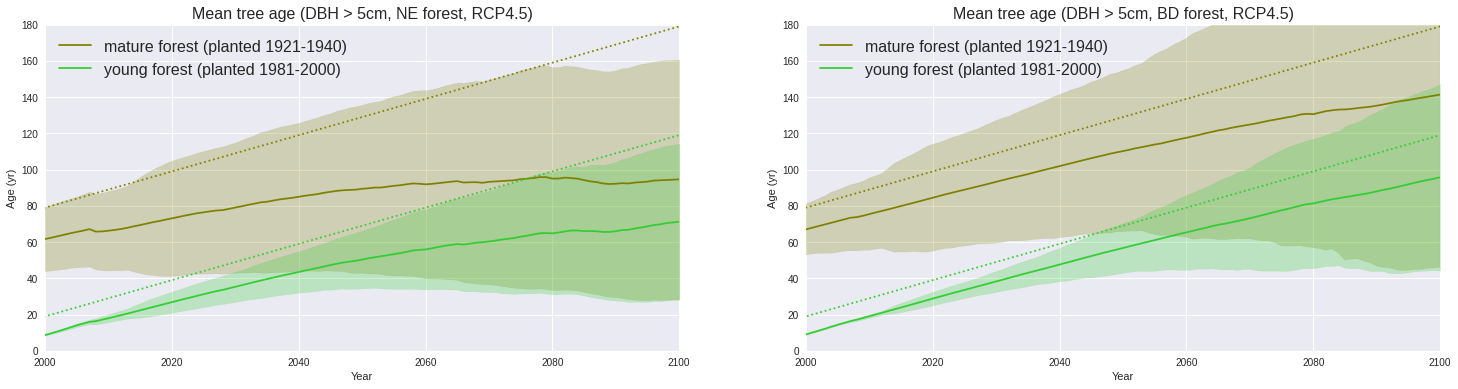

In [7]:

color_vals={ 1910 : 'olive', 1960 : 'darkgreen', 1930 : 'olive', 1990 : 'limegreen', 2000: 'lightgreen' }
style={ 0 : '--', 1 : '-' }
sizes={50: 1, 100: 3.5, 200: 5}



fig, ax = plt.subplots(1, 2, figsize=(25, 6))
for forest_idx, forest_type in enumerate(forest_types):
    for planting_time in [1930, 1990]:

        simname = 'forest_' + forest_type + '_rcp_rcp45_usage_100_residence_100_man_100_salvage_0_disturb_' + str(planting_time) + '_increaseddist_2_newharv100patch_insdistfix'

        cpool = pd.read_csv(data_path + simname + '/agestruct_forest.out', delim_whitespace=True).groupby('Year').mean().reset_index()

        for idx, agetype in enumerate([('Mean5cm', 'Std5cm')]):
            ax[forest_idx].plot(cpool.Year, cpool[agetype[0]], color=color_vals[planting_time], label=agenames[planting_time] + ' forest (planted ' + str(planting_time-9) + '-' + str(planting_time+10) + ')')
            cpool = cpool[cpool.Year > planting_time]
            ax[forest_idx].plot(cpool.Year, cpool.Max, color=color_vals[planting_time], linestyle=':')
            ax[forest_idx].fill_between(cpool.Year, cpool[agetype[0]] - cpool[agetype[1]], cpool[agetype[0]] + cpool[agetype[1]], alpha=0.25, color=color_vals[planting_time])
            ax[forest_idx].legend(fontsize=16)


            ax[forest_idx].set_title('Mean tree age (DBH > 5cm, ' + forest_type.upper() + ' forest, RCP4.5)', fontsize=16)
            ax[forest_idx].set_ylim([0, 180])
            ax[forest_idx].set_xlim([2000, 2100])
            ax[forest_idx].set_ylabel('Age (yr)')
            ax[forest_idx].set_xlabel('Year')

# Carbon Pools

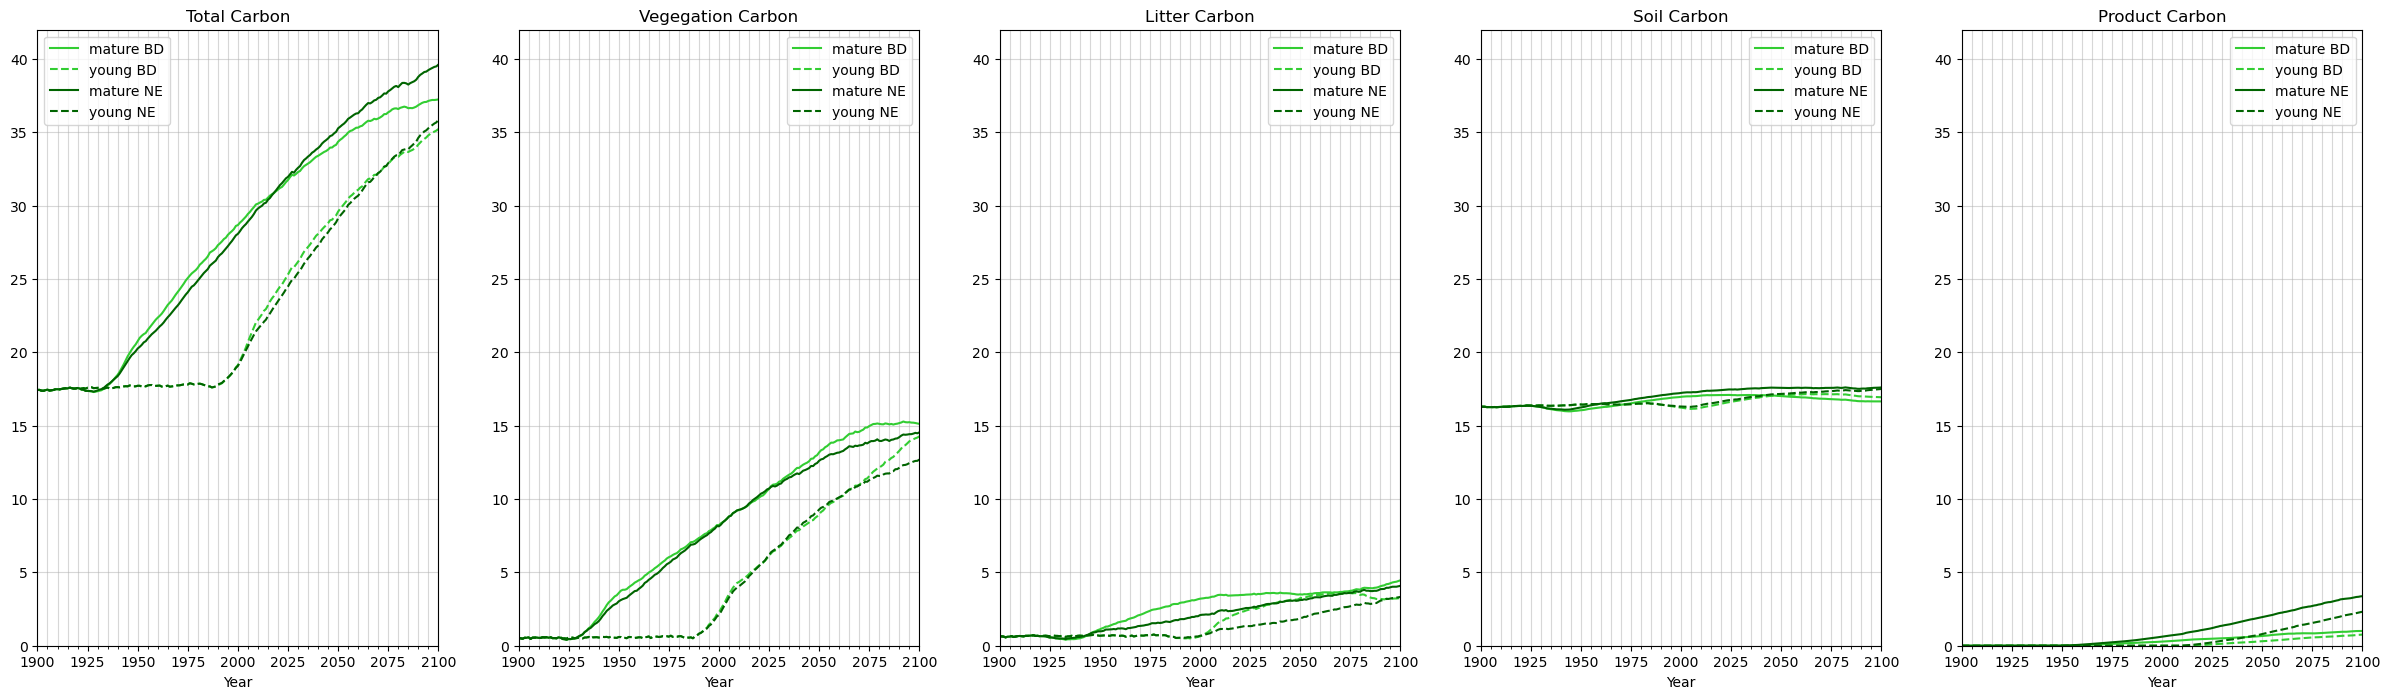

In [8]:
colors = {'ne': 'darkgreen', 'bd': 'limegreen'}
linestyle = {1930: '-', 1990: '--', 0: '-', 1: ':'}


pools = ['Total', 'VegC', 'LitterC', 'SoilC', 'HarvSlowC']
poolname = {
    'Total': 'Total Carbon',
    'VegC': 'Vegegation Carbon',
    'LitterC': 'Litter Carbon',
    'SoilC': 'Soil Carbon',
    'HarvSlowC': 'Product Carbon',
}

plt.style.use('default')

for incdist in [1]:
    for man in [100]:
        fig, ax = plt.subplots(1, len(pools), figsize=(6 * len(pools), 8))
        for forest_type in ['bd', 'ne']:
            for rcp in ['rcp45']:
                for usage in [100]:
                    for salvage in [1]:
                        for residence in [100]:
                            for forest_plant_time in [1930, 1990]:

                                if man == 0 and salvage == 1:
                                    continue

                                simname = 'forest_' + forest_type + '_rcp_' + rcp + '_usage_' + str(usage) + '_residence_' + str(residence) + '_man_' + str(man) + '_salvage_' + str(salvage) + '_disturb_' + str(forest_plant_time) + '_increaseddist_' + str(incdist) + '_newharv100patch_insdistfix'
                                cpool = ph.read_for_years(data_path + simname + '/' + 'cpool.out', 1900, 2100, lons_lats_of_interest=None).groupby('Year').mean()
                                harv = ph.read_for_years(data_path + simname + '/' + 'forest_harvest.out', 1900, 2100, lons_lats_of_interest=None).groupby('Year').mean()
                                cpool['totharv_stemC'] = harv['totharv_stemC']
                                cpool['totharv_toflux'] = harv['totharv_toflux']
                                cpool['totharv_toprod'] = harv['totharv_toprod']
                                cpool['totharv_tol'] = harv['totharv_tol']
                                cpool['Forest'] = cpool['Total'] - cpool['HarvSlowC']

                                for pool_idx, pool in enumerate(pools):
                                    cpool.reset_index().rolling(1).mean().plot(x='Year', y=pool, ax=ax[pool_idx], label=agenames[forest_plant_time] + ' ' + forest_type.upper(), color=colors[forest_type], style=linestyle[forest_plant_time])
                                    ax[pool_idx].set_title(poolname[pool])
                                    ax[pool_idx].set_xlim([1900, 2100])
                                    ax[pool_idx].set_ylim([0, 42])
                                    minor_ticks = np.arange(1900, 2100, 5)
                                    ax[pool_idx].set_xticks(minor_ticks, minor=True)
                                    ax[pool_idx].grid(which='minor', alpha=0.5)
                                    ax[pool_idx].grid(which='major', alpha=0.5)

# Bar Plots

In [9]:
substitution_data_2050 = subs_analysis_functions.get_subs_data(data_path, gc=all_cells, base_year=2020, end_year=2050, dir_extension='_newharv100patch_insdistfix', rcp45=True, roll_window=5, incdist=DistIncrease.EXP.value)

In [10]:
substitution_data_2100 = subs_analysis_functions.get_subs_data(data_path, gc=all_cells, base_year=2020, end_year=2100, dir_extension='_newharv100patch_insdistfix', rcp45=True, roll_window=5, incdist=DistIncrease.EXP.value)

## Default

decarb 0.25 ne : substitution/total 0.34464806594579317
decarb 0.5 ne : substitution/total 0.3055856157181273
decarb 0.75 ne : substitution/total 0.24929687778040305
Forest sink 2.770600000000009
Product sink 0.5096799999999998
Substitution 1.0893301733282108
Product/forest sink 0.15537698001390077
decarb 0.25 ne : substitution/total 0.16100891581077084
decarb 0.5 ne : substitution/total 0.137689621727221
decarb 0.75 ne : substitution/total 0.10670424877995328
Forest sink 4.3629599999999975
Product sink 0.39788000000000007
Substitution 0.5686827179774818
Product/forest sink 0.08357348703170035
decarb 0.25 bd : substitution/total 0.3372464646924655
decarb 0.5 bd : substitution/total 0.29820528269530205
decarb 0.75 bd : substitution/total 0.24227903614138505
Forest sink 2.661920000000002
Product sink 0.1460399999999999
Substitution 0.8978369014091374
Product/forest sink 0.05200928788159368
decarb 0.25 bd : substitution/total 0.13850193635829705
decarb 0.5 bd : substitution/total 0.118756

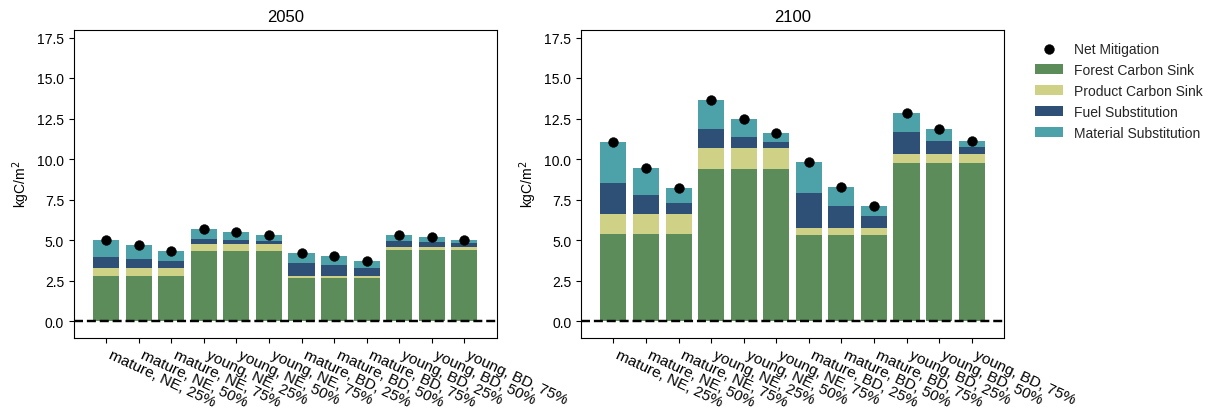

In [11]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
subs_analysis_functions.plot_bar_plot_forest_types(ax[0], substitution_data_2050, min_y=-1, max_y=18, rcp='rcp45', man=100, plotaddition=2050)
subs_analysis_functions.plot_bar_plot_forest_types(ax[1], substitution_data_2100, min_y=-1, max_y=18, rcp='rcp45', man=100, plotaddition=2100)
plt.legend(bbox_to_anchor=(1.5, 1.0))

## Increased harvest intensity

decarb 0.25 ne : substitution/total 0.4714033468914493
decarb 0.5 ne : substitution/total 0.4270542826920164
decarb 0.75 ne : substitution/total 0.3594891129306941
Forest sink 1.9263599999999954
Product sink 0.8803200000000002
Substitution 1.575259568337586
Product/forest sink 0.313651716618924
decarb 0.25 ne : substitution/total 0.23324964133976517
decarb 0.5 ne : substitution/total 0.20203926743446005
decarb 0.75 ne : substitution/total 0.15929234102872364
Forest sink 3.831680000000002
Product sink 0.60612
Substitution 0.8408482347862404
Product/forest sink 0.1365811888773716
decarb 0.25 bd : substitution/total 0.4804306405307997
decarb 0.5 bd : substitution/total 0.43518215025632356
decarb 0.75 bd : substitution/total 0.3661409262360433
Forest sink 1.8815999999999953
Product sink 0.34911999999999993
Substitution 1.2885480712979729
Product/forest sink 0.15650552288050523
decarb 0.25 bd : substitution/total 0.2007867907850794
decarb 0.5 bd : substitution/total 0.17395313059877915
deca

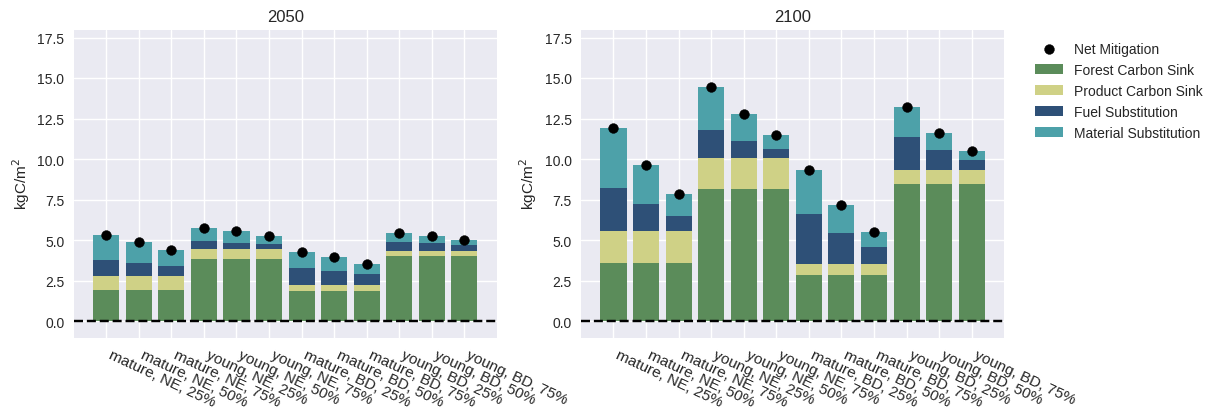

In [12]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
subs_analysis_functions.plot_bar_plot_forest_types(ax[0], substitution_data_2050, min_y=-1, max_y=18, rcp='rcp45', man=150, plotaddition=2050)
subs_analysis_functions.plot_bar_plot_forest_types(ax[1], substitution_data_2100, min_y=-1, max_y=18, rcp='rcp45', man=150, plotaddition=2100)
plt.legend(bbox_to_anchor=(1.5, 1.0))

## Constant disturbance rates

In [13]:
substitution_data_2050_const = subs_analysis_functions.get_subs_data(data_path, gc=all_cells, end_year=2050, dir_extension='_newharv100patch_insdistfix', rcp45=True, roll_window=5, incdist=DistIncrease.CONSTANT.value)
substitution_data_2100_const = subs_analysis_functions.get_subs_data(data_path, gc=all_cells, end_year=2100, dir_extension='_newharv100patch_insdistfix', rcp45=True, roll_window=5, incdist=DistIncrease.CONSTANT.value)

decarb 0.25 ne : substitution/total 0.3382076003857274
decarb 0.5 ne : substitution/total 0.29935185347670523
decarb 0.75 ne : substitution/total 0.24356317209370737
Forest sink 3.032959999999999
Product sink 0.56768
Substitution 1.1593609242887466
Product/forest sink 0.15766086029150375
decarb 0.25 ne : substitution/total 0.16218010292911025
decarb 0.5 ne : substitution/total 0.13880090749395624
decarb 0.75 ne : substitution/total 0.10773151610119315
Forest sink 4.51436
Product sink 0.42036
Substitution 0.5958126693121797
Product/forest sink 0.08518416445107323
decarb 0.25 bd : substitution/total 0.3369865270802231
decarb 0.5 bd : substitution/total 0.29798960485736536
decarb 0.75 bd : substitution/total 0.2421416521980384
Forest sink 2.6855600000000024
Product sink 0.14812000000000003
Substitution 0.9053828581430869
Product/forest sink 0.052271251517461356
decarb 0.25 bd : substitution/total 0.13912630040870344
decarb 0.5 bd : substitution/total 0.11935407673489246
decarb 0.75 bd : s

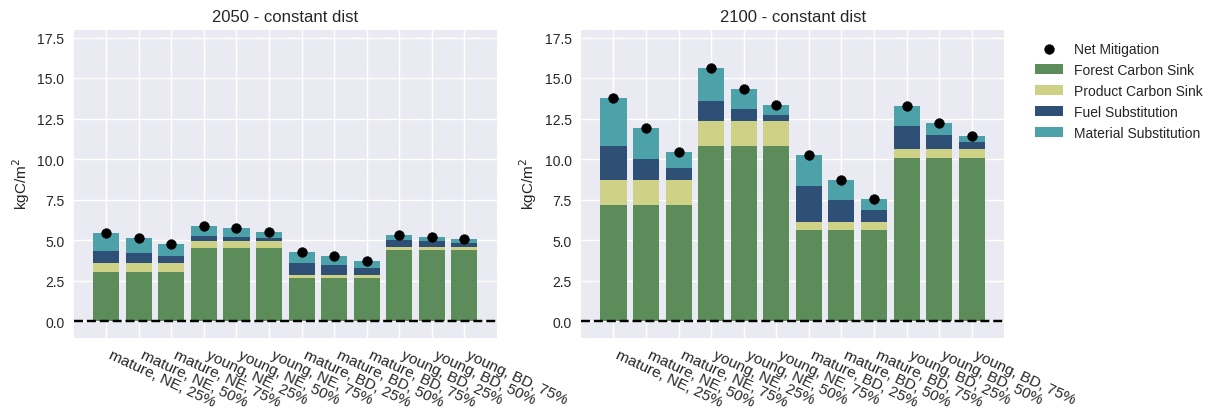

In [14]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
subs_analysis_functions.plot_bar_plot_forest_types(ax[0], substitution_data_2050_const, min_y=-1, max_y=18, rcp='rcp45', man=100, plotaddition='2050 - constant dist')
subs_analysis_functions.plot_bar_plot_forest_types(ax[1], substitution_data_2100_const, min_y=-1, max_y=18, rcp='rcp45', man=100, plotaddition='2100 - constant dist')
plt.legend(bbox_to_anchor=(1.5, 1.0))

# Violin Plots

## Default

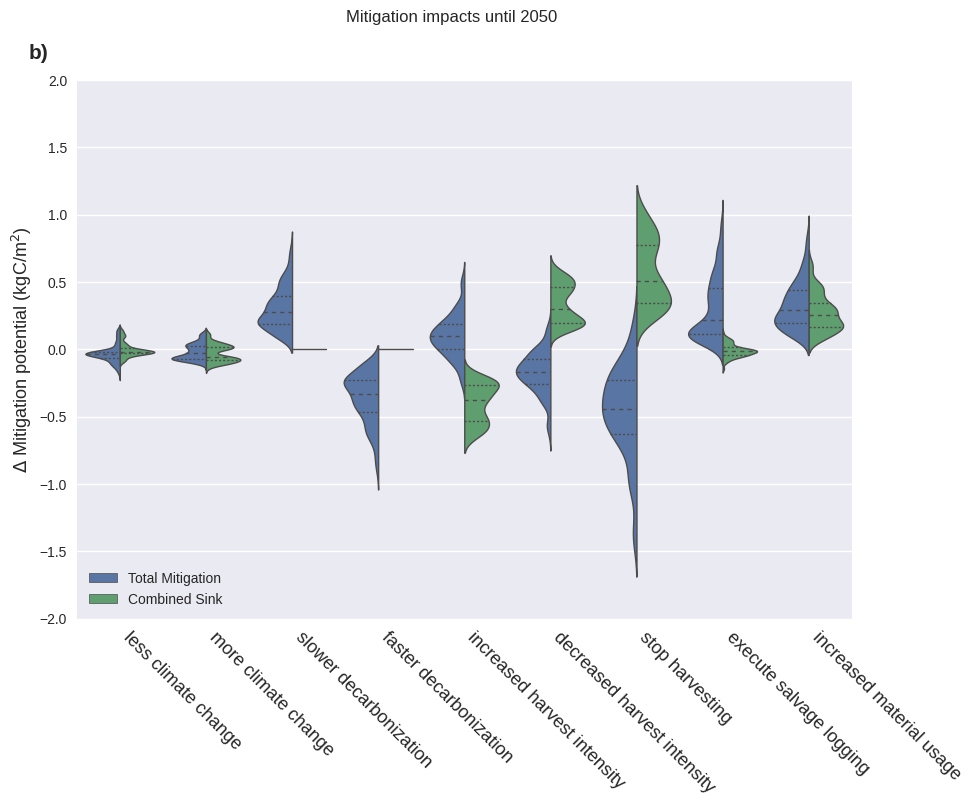

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
diffs_as_df_2050, all_diffs_2050 = subs_analysis_functions.plot_violins(fig, ax, data_path, all_cells, base_year=2020, end_year=2050, rcp45=True, middle_decarb_only=True, letter='b)', ymin=-2, ymax=2, incdist=DistIncrease.EXP.value)

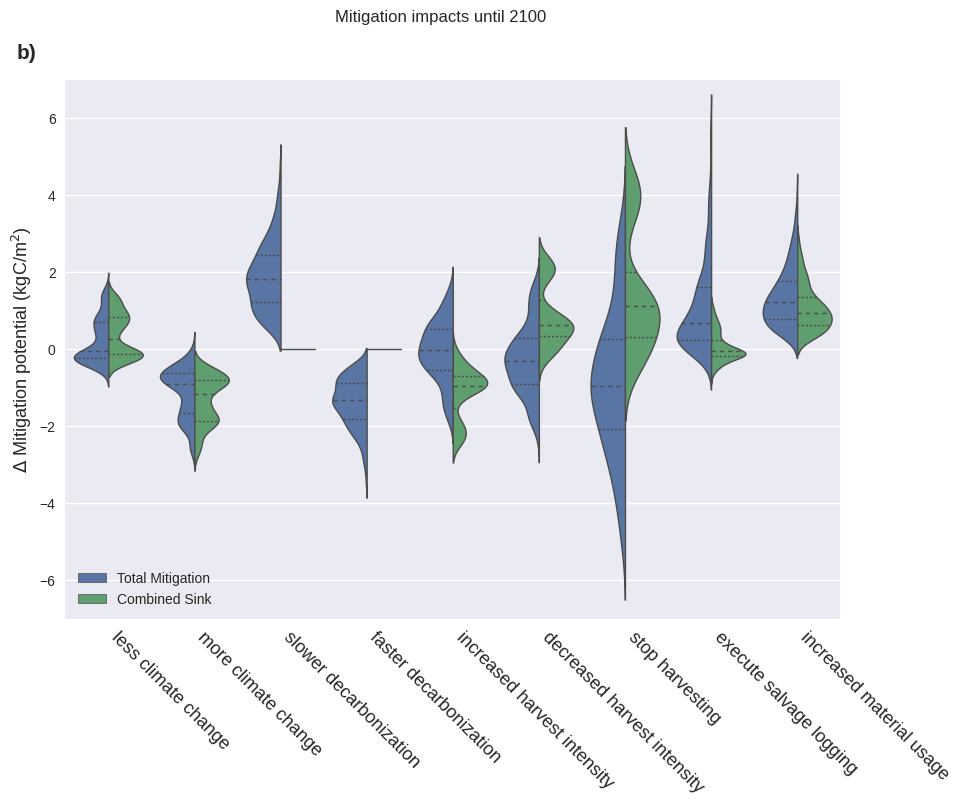

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
diffs_as_df_2100, all_diffs_2100 = subs_analysis_functions.plot_violins(fig, ax, data_path, all_cells, base_year=2020, rcp45=True, middle_decarb_only=True, letter='b)', ymin=-7, ymax=7, incdist=DistIncrease.EXP.value)

### Values for Text

In [17]:
diffs_as_df_2050.groupby(['variable', 'Mitigation Type'])['value'].apply(lambda grp: {
    'Min': '{:.1f}'.format(grp.min()),
    'Median': '{:.1f}'.format(grp.median()),
    'Max': '{:.1f}'.format(grp.max())
}).unstack()

Min Median   Max
variable                    Mitigation Type                    
decreased harvest intensity Combined Sink      0.1    0.3   0.6
                            Total Mitigation  -0.7   -0.2   0.2
execute salvage logging     Combined Sink     -0.1   -0.0   0.1
                            Total Mitigation   0.0    0.2   1.0
faster decarbonization      Combined Sink      0.0    0.0   0.0
                            Total Mitigation  -0.9   -0.3  -0.1
increased harvest intensity Combined Sink     -0.7   -0.4  -0.2
                            Total Mitigation  -0.3    0.1   0.5
increased material usage    Combined Sink      0.1    0.3   0.6
                            Total Mitigation   0.1    0.3   0.9
less climate change         Combined Sink     -0.1   -0.0   0.1
                            Total Mitigation  -0.2   -0.0   0.1
more climate change         Combined Sink     -0.1   -0.1   0.1
                            Total Mitigation  -0.1   -0.0   0.1
slower decarbonization      Combined Sink      0.0    0.0   0.0
                            Total Mitigation   0.1    0.3   0.8
stop harvesting             Combined Sink      0.2    0.5   1.0
                            Total Mitigation  -1.4   -0.4   0.2

In [18]:
diffs_as_df_2100.groupby(['variable', 'Mitigation Type'])['value'].apply(lambda grp: {
    'Min': '{:.1f}'.format(grp.min()),
    'Median': '{:.1f}'.format(grp.median()),
    'Max': '{:.1f}'.format(grp.max())
}).unstack()

Min Median   Max
variable                    Mitigation Type                    
decreased harvest intensity Combined Sink     -0.3    0.6   2.4
                            Total Mitigation  -2.4   -0.3   1.8
execute salvage logging     Combined Sink     -0.7   -0.1   1.1
                            Total Mitigation  -0.4    0.7   5.9
faster decarbonization      Combined Sink      0.0    0.0   0.0
                            Total Mitigation  -3.4   -1.3  -0.4
increased harvest intensity Combined Sink     -2.5   -0.9   0.0
                            Total Mitigation  -1.9   -0.0   1.6
increased material usage    Combined Sink      0.3    0.9   2.8
                            Total Mitigation   0.3    1.2   4.0
less climate change         Combined Sink     -0.3    0.3   1.4
                            Total Mitigation  -0.6   -0.1   1.6
more climate change         Combined Sink     -2.8   -1.2  -0.4
                            Total Mitigation  -2.6   -0.9   0.0
slower decarbonization      Combined Sink      0.0    0.0   0.0
                            Total Mitigation   0.5    1.8   4.8
stop harvesting             Combined Sink     -0.7    1.1   4.6
                            Total Mitigation  -5.1   -1.0   3.4

### Violins for different forests

['less climate change', 'more climate change', 'slower decarbonization', 'faster decarbonization', 'increased harvest intensity', 'decreased harvest intensity', 'stop harvesting', 'execute salvage logging', 'increased material usage']
['less climate change', 'more climate change', 'slower decarbonization', 'faster decarbonization', 'increased harvest intensity', 'decreased harvest intensity', 'stop harvesting', 'execute salvage logging', 'increased material usage']


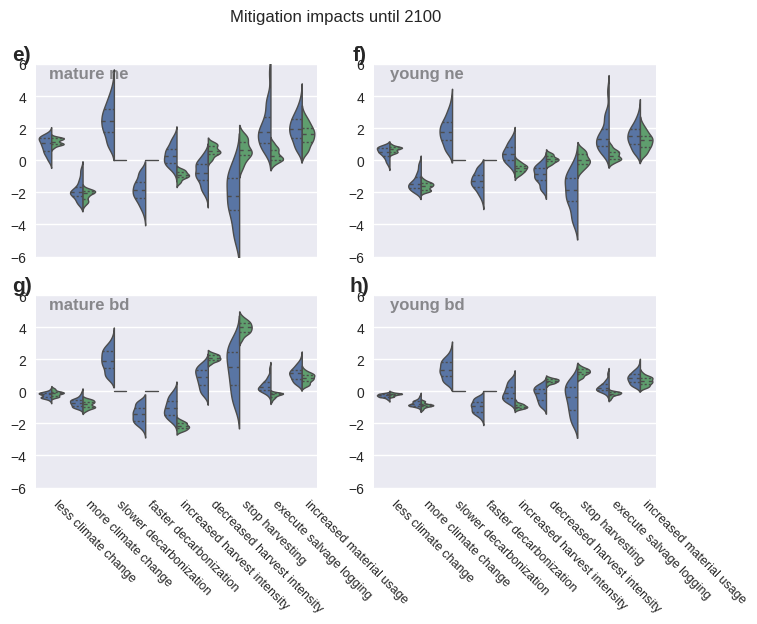

In [19]:
fig, ax = plt.subplots(2, 2)

letters = ['e', 'f', 'g', 'h']
idx=0

for type_idx, forest_type in enumerate(['ne', 'bd']):
    for distidx, forest_plant_time in enumerate([1930, 1990]):
        _, _ = subs_analysis_functions.plot_violins(fig, ax[type_idx, distidx], data_path, all_cells, rcp_only=None, rcp45=True, middle_decarb_only=True, forest_type=forest_type, disturb=forest_plant_time, ymin=-6, ymax=6, letter=letters[idx] + ')', incdist=2)
        idx+=1

['less climate change', 'more climate change', 'slower decarbonization', 'faster decarbonization', 'increased harvest intensity', 'decreased harvest intensity', 'stop harvesting', 'execute salvage logging', 'increased material usage']
['less climate change', 'more climate change', 'slower decarbonization', 'faster decarbonization', 'increased harvest intensity', 'decreased harvest intensity', 'stop harvesting', 'execute salvage logging', 'increased material usage']


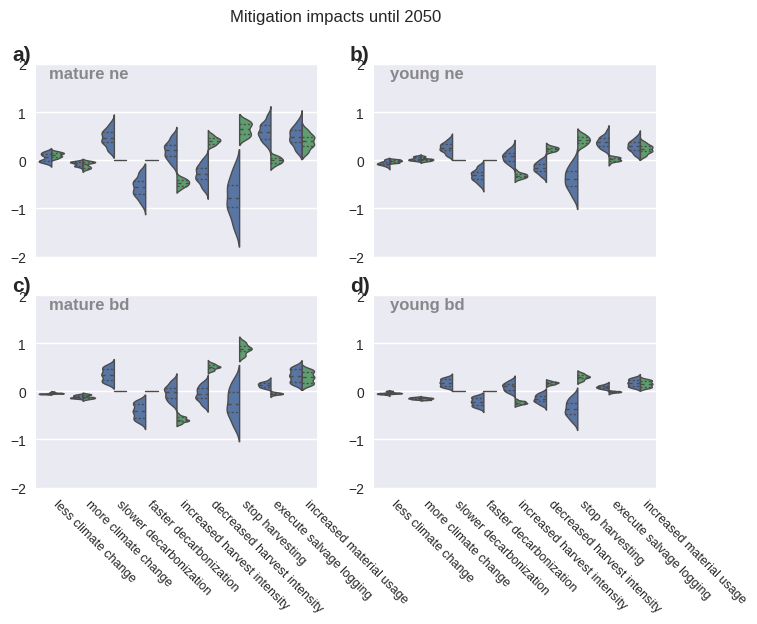

In [20]:
fig, ax = plt.subplots(2, 2)

letters = ['a', 'b', 'c', 'd']
idx=0

for type_idx, forest_type in enumerate(['ne', 'bd']):
    for distidx, forest_plant_time in enumerate([1930, 1990]):
        _, _ = subs_analysis_functions.plot_violins(fig, ax[type_idx, distidx], data_path, all_cells, rcp_only=None, rcp45=True, middle_decarb_only=True, forest_type=forest_type, disturb=forest_plant_time, ymin=-2, ymax=2, letter=letters[idx] + ')', incdist=2, end_year=2050)
        idx+=1

## Linear disturbance increase

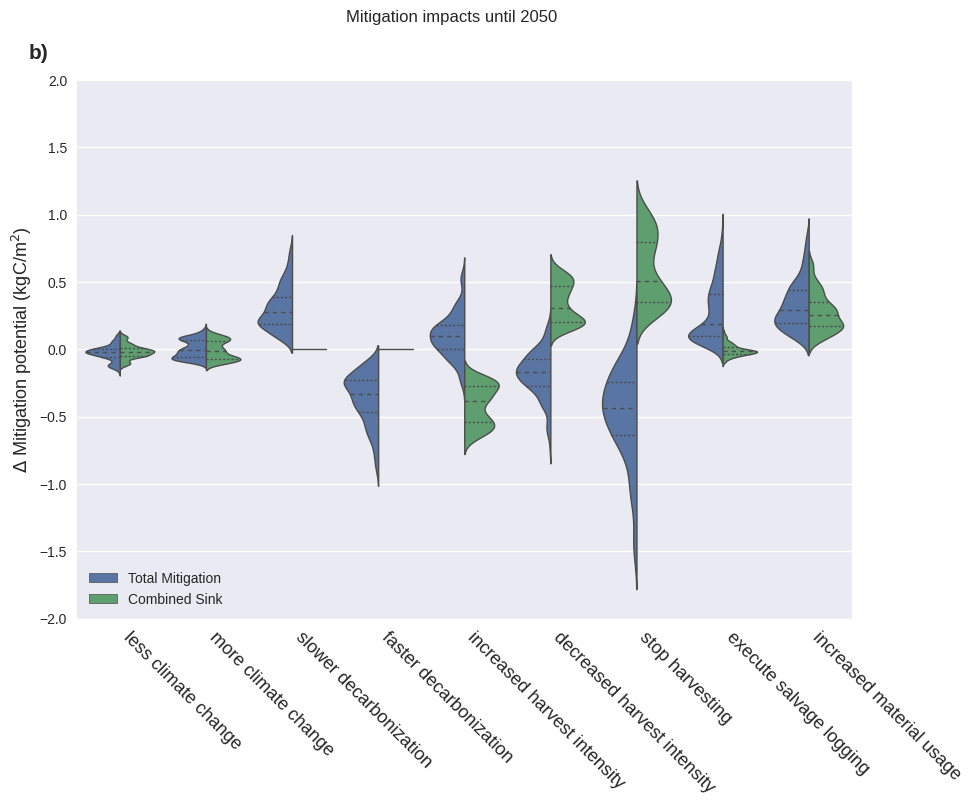

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
diffs_as_df_2050_lin, all_diffs_2050_lin = subs_analysis_functions.plot_violins(fig, ax, data_path, all_cells, base_year=2020, end_year=2050, rcp45=True, middle_decarb_only=True, letter='b)', ymin=-2, ymax=2, incdist=DistIncrease.LINEAR.value)

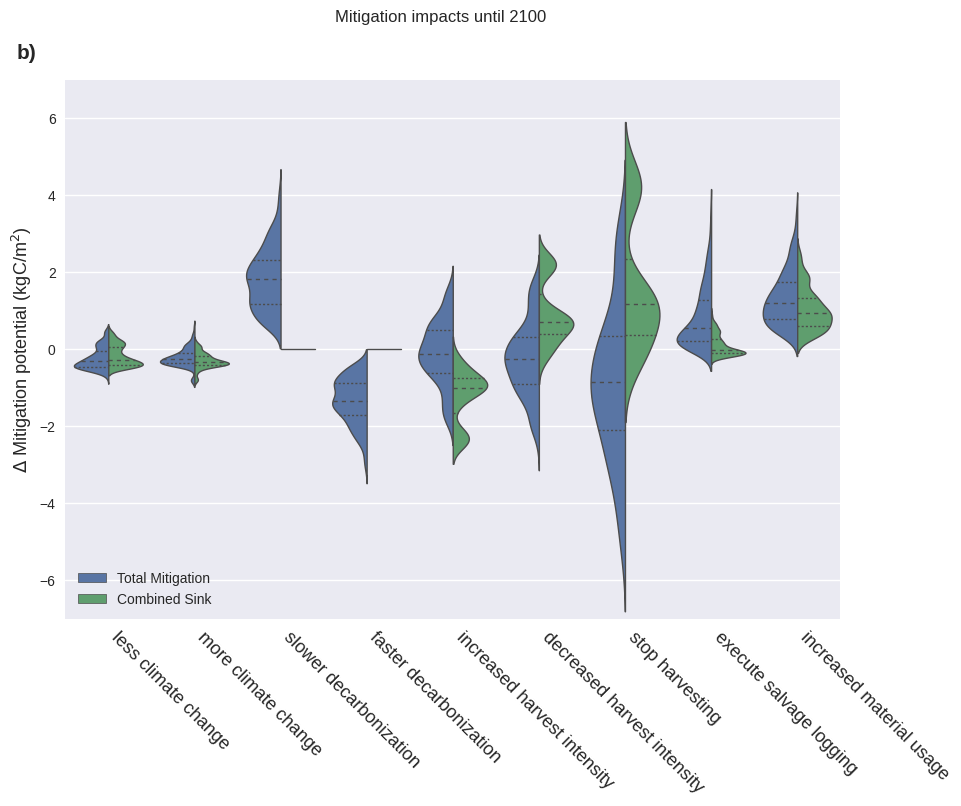

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
diffs_as_df_2100_lin, all_diffs_2100_lin = subs_analysis_functions.plot_violins(fig, ax, data_path, all_cells, base_year=2020, end_year=2100, rcp45=True, middle_decarb_only=True, letter='b)', ymin=-7, ymax=7, incdist=DistIncrease.LINEAR.value)

In [23]:
diffs_as_df_2100_lin.groupby(['variable', 'Mitigation Type'])['value'].apply(lambda grp: {
    'Min': '{:.1f}'.format(grp.min()),
    'Median': '{:.1f}'.format(grp.median()),
    'Max': '{:.1f}'.format(grp.max())
}).unstack()

Min Median   Max
variable                    Mitigation Type                    
decreased harvest intensity Combined Sink     -0.4    0.7   2.5
                            Total Mitigation  -2.5   -0.3   1.8
execute salvage logging     Combined Sink     -0.2   -0.0   0.9
                            Total Mitigation  -0.1    0.6   3.7
faster decarbonization      Combined Sink      0.0    0.0   0.0
                            Total Mitigation  -3.1   -1.3  -0.4
increased harvest intensity Combined Sink     -2.5   -1.0  -0.1
                            Total Mitigation  -2.0   -0.1   1.6
increased material usage    Combined Sink      0.3    0.9   2.5
                            Total Mitigation   0.3    1.2   3.6
less climate change         Combined Sink     -0.5   -0.3   0.4
                            Total Mitigation  -0.7   -0.3   0.5
more climate change         Combined Sink     -0.8   -0.3   0.2
                            Total Mitigation  -0.8   -0.3   0.6
slower decarbonization      Combined Sink      0.0    0.0   0.0
                            Total Mitigation   0.5    1.8   4.2
stop harvesting             Combined Sink     -0.7    1.2   4.7
                            Total Mitigation  -5.3   -0.8   3.5

## Constant disturbance rates

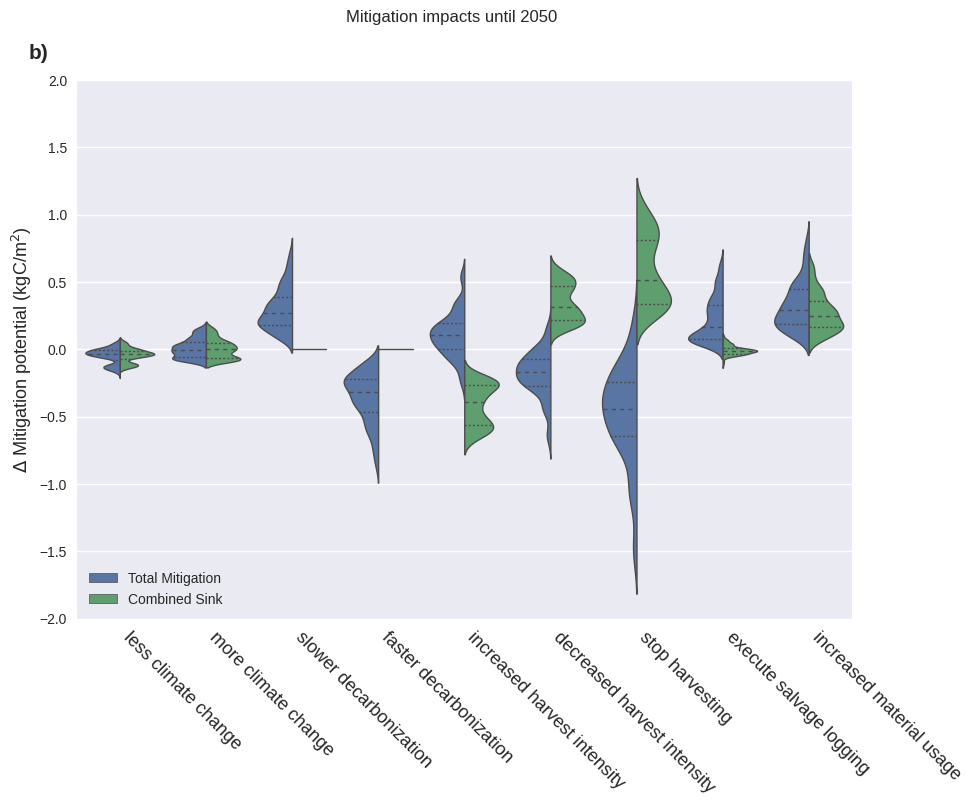

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
diffs_as_df_2050_const, all_diffs_2050_const = subs_analysis_functions.plot_violins(fig, ax, data_path, all_cells, base_year=2020, end_year=2050, rcp45=True, middle_decarb_only=True, letter='b)', ymin=-2, ymax=2, incdist=DistIncrease.CONSTANT.value)

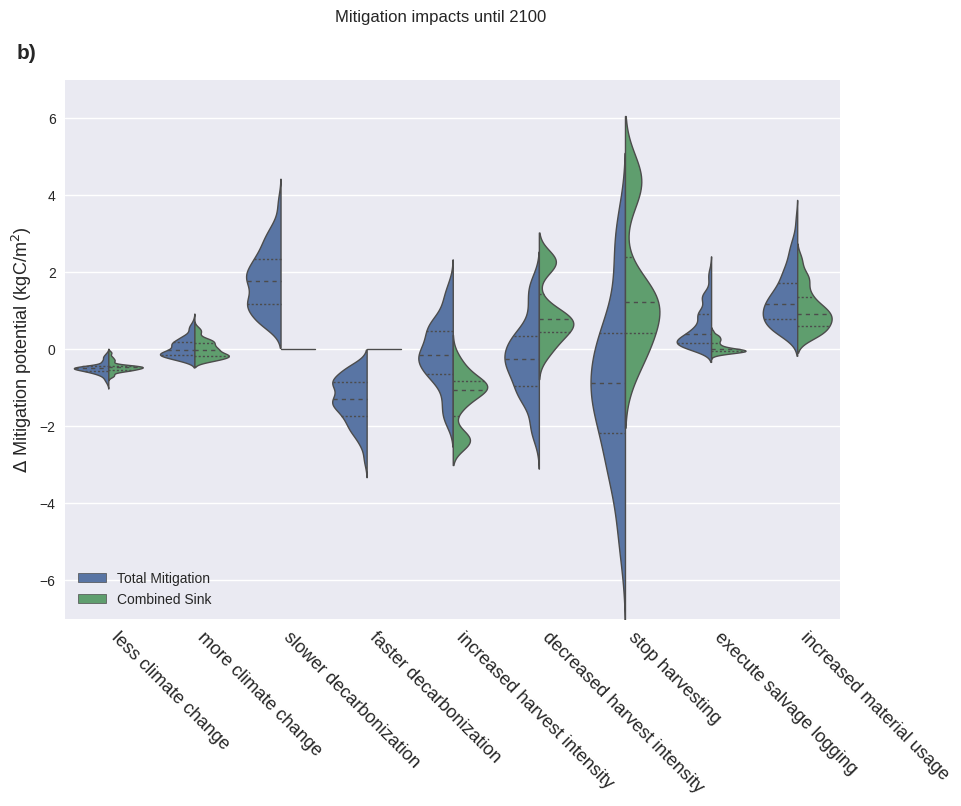

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
diffs_as_df_2100_const, all_diffs_2100_const = subs_analysis_functions.plot_violins(fig, ax, data_path, all_cells, base_year=2020, end_year=2100, rcp45=True, middle_decarb_only=True, letter='b)', ymin=-7, ymax=7, incdist=DistIncrease.CONSTANT.value)

In [26]:
diffs_as_df_2100_const.groupby(['variable', 'Mitigation Type'])['value'].apply(lambda grp: {
    'Min': '{:.1f}'.format(grp.min()),
    'Median': '{:.1f}'.format(grp.median()),
    'Max': '{:.1f}'.format(grp.max())
}).unstack()

Min Median   Max
variable                    Mitigation Type                    
decreased harvest intensity Combined Sink     -0.3    0.8   2.5
                            Total Mitigation  -2.5   -0.3   1.9
execute salvage logging     Combined Sink     -0.2   -0.0   0.5
                            Total Mitigation  -0.0    0.4   2.1
faster decarbonization      Combined Sink      0.0    0.0   0.0
                            Total Mitigation  -2.9   -1.3  -0.4
increased harvest intensity Combined Sink     -2.6   -1.1  -0.1
                            Total Mitigation  -2.0   -0.1   1.8
increased material usage    Combined Sink      0.3    0.9   2.4
                            Total Mitigation   0.3    1.2   3.4
less climate change         Combined Sink     -0.7   -0.5  -0.1
                            Total Mitigation  -0.9   -0.5  -0.1
more climate change         Combined Sink     -0.3   -0.0   0.6
                            Total Mitigation  -0.3   -0.0   0.8
slower decarbonization      Combined Sink      0.0    0.0   0.0
                            Total Mitigation   0.5    1.8   3.9
stop harvesting             Combined Sink     -0.8    1.2   4.8
                            Total Mitigation  -5.6   -0.9   3.6

# Violin deep dives

In [27]:
def deep_dive(bd_ne, aspect, miti_type='Combined Sink', ylim=50, comparison_direction=1, use_percentage_decarbonization=False, title=''):
    plt.style.use('seaborn')
    assert bd_ne['variable'].unique()[0] == aspect, "wrong diff dataset. Dataset says " + bd_ne['variable'].unique()[0] + " and you wanted " + aspect

    bd_better = bd_ne[(bd_ne['value']*comparison_direction > 0) & (bd_ne['Mitigation Type'] == miti_type)].reset_index()

    if len(bd_better) == 0:
        print('no data points where the aspect', aspect, 'was fulfilled. Exiting.')
        return

    if not aspect == 'Young vs old forest' and not aspect == 'clearcut old forests':
        bd_better['Age'] = bd_better['Disturbtime'].apply(lambda x: 'mature' if x==1930 else 'young')
        del bd_better['Disturbtime']

    bd_better['Decarbonization'] = bd_better['percentage_decarbonization_by_2050'].apply(lambda x: int(x*100))
    del bd_better['percentage_decarbonization_by_2050']

    if not use_percentage_decarbonization:
        bd_better = bd_better[(bd_better['Decarbonization'] == 0.5)]
        del bd_better['Decarbonization']

    del bd_better['value']
    del bd_better['Mitigation Type']
    del bd_better['variable']
    del bd_better['Carbon Sink A']
    del bd_better['Carbon Sink B']
    del bd_better['Miti A']
    del bd_better['Miti B']

    bd_better.rename(columns={'Man': 'Harvest Intensity', 'Residence': 'Cascade Usage', 'Usage': 'Material Usage'}, inplace=True)

    fig, ax = plt.subplots(1, len(bd_better.columns), figsize=(10, 3))
    for idx, col in enumerate(bd_better.columns):
        bd_better[col].value_counts().plot.bar(ax=ax[idx], title=col)
        ax[idx].set_ylim([0, ylim])

    plt.tight_layout()
    plt.suptitle(title + ' (' + miti_type + ', n=' + str(len(bd_better)) + ')', y=1.05, fontsize=14)

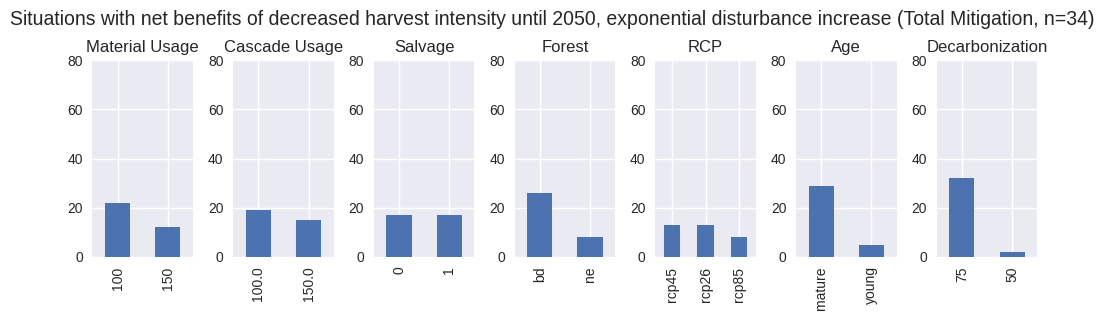

In [28]:
deep_dive(all_diffs_2050[5], 'decreased harvest intensity', comparison_direction=1, miti_type='Total Mitigation', use_percentage_decarbonization=True, ylim=80, title='Situations with net benefits of decreased harvest intensity until 2050, exponential disturbance increase')

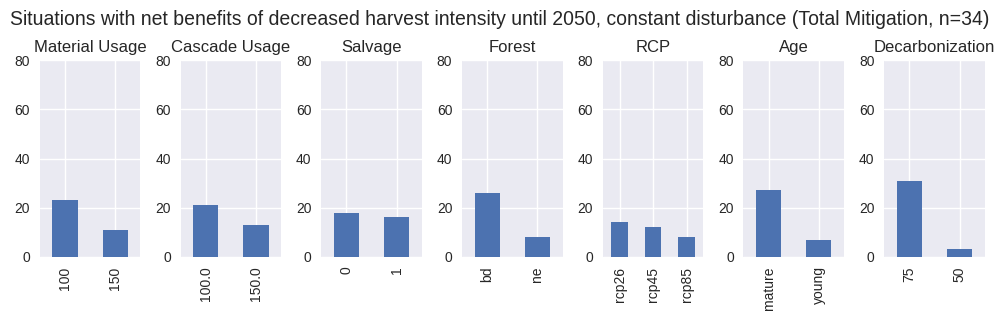

In [29]:
deep_dive(all_diffs_2050_const[5], 'decreased harvest intensity', comparison_direction=1, miti_type='Total Mitigation', use_percentage_decarbonization=True, ylim=80, title='Situations with net benefits of decreased harvest intensity until 2050, constant disturbance')

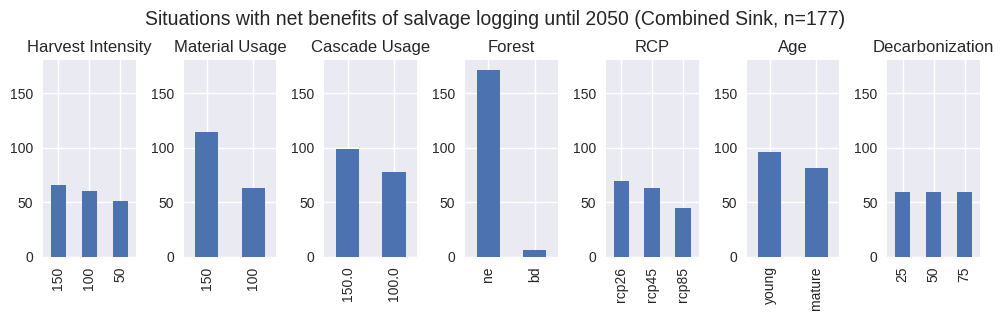

In [30]:
deep_dive(all_diffs_2100[7], 'execute salvage logging', comparison_direction=1, miti_type='Combined Sink', use_percentage_decarbonization=True, ylim=180, title='Situations with net benefits of salvage logging until 2050')

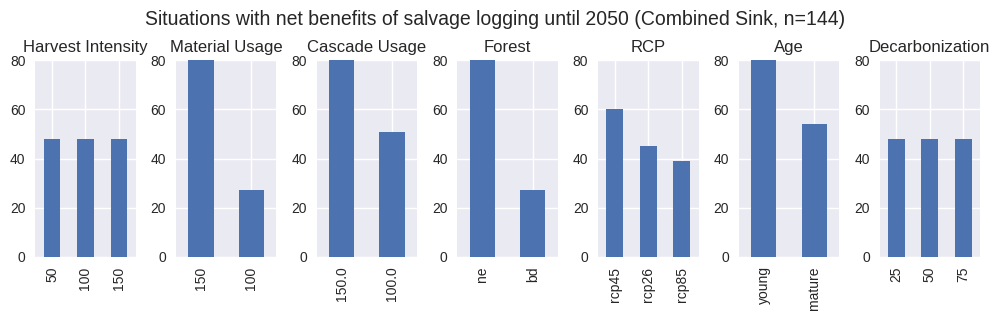

In [31]:
deep_dive(all_diffs_2050[7], 'execute salvage logging', comparison_direction=1, miti_type='Combined Sink', use_percentage_decarbonization=True, ylim=80, title='Situations with net benefits of salvage logging until 2050')

# Bubble plots

In [32]:
subs_data_global_01_50_patches_full_decarb = subs_analysis_functions.get_subs_data(data_path, gc=all_cells, end_year=2100, dir_extension='_newharv100patch_insdistfix', rcp45=True, roll_window=5, incdist=2)
subs_data_global_01_50_patches_full_decarb_2050 = subs_analysis_functions.get_subs_data(data_path, gc=all_cells, end_year=2050, dir_extension='_newharv100patch_insdistfix', rcp45=True, roll_window=5, incdist=2)

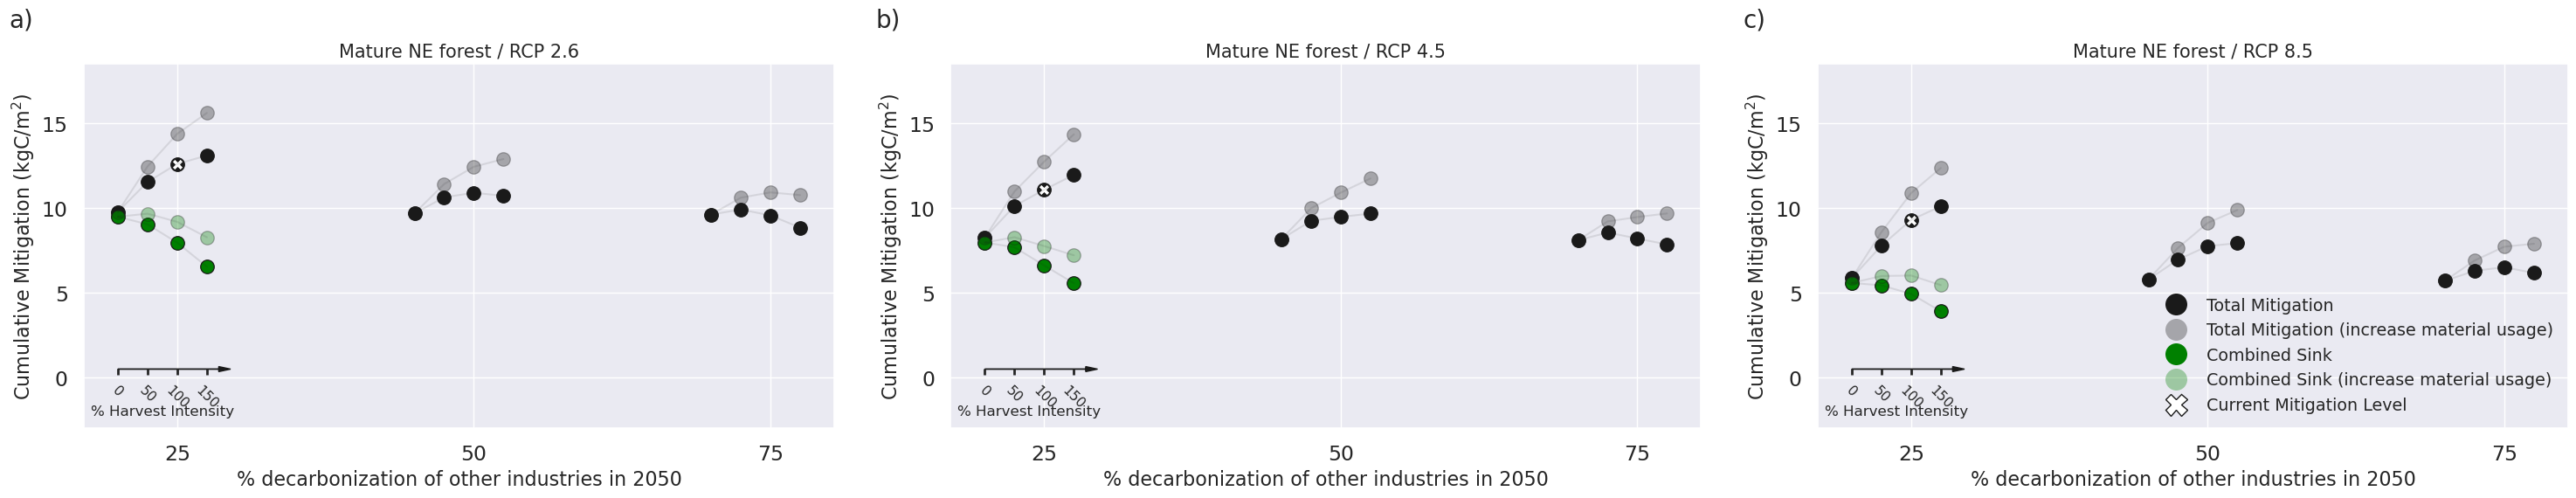

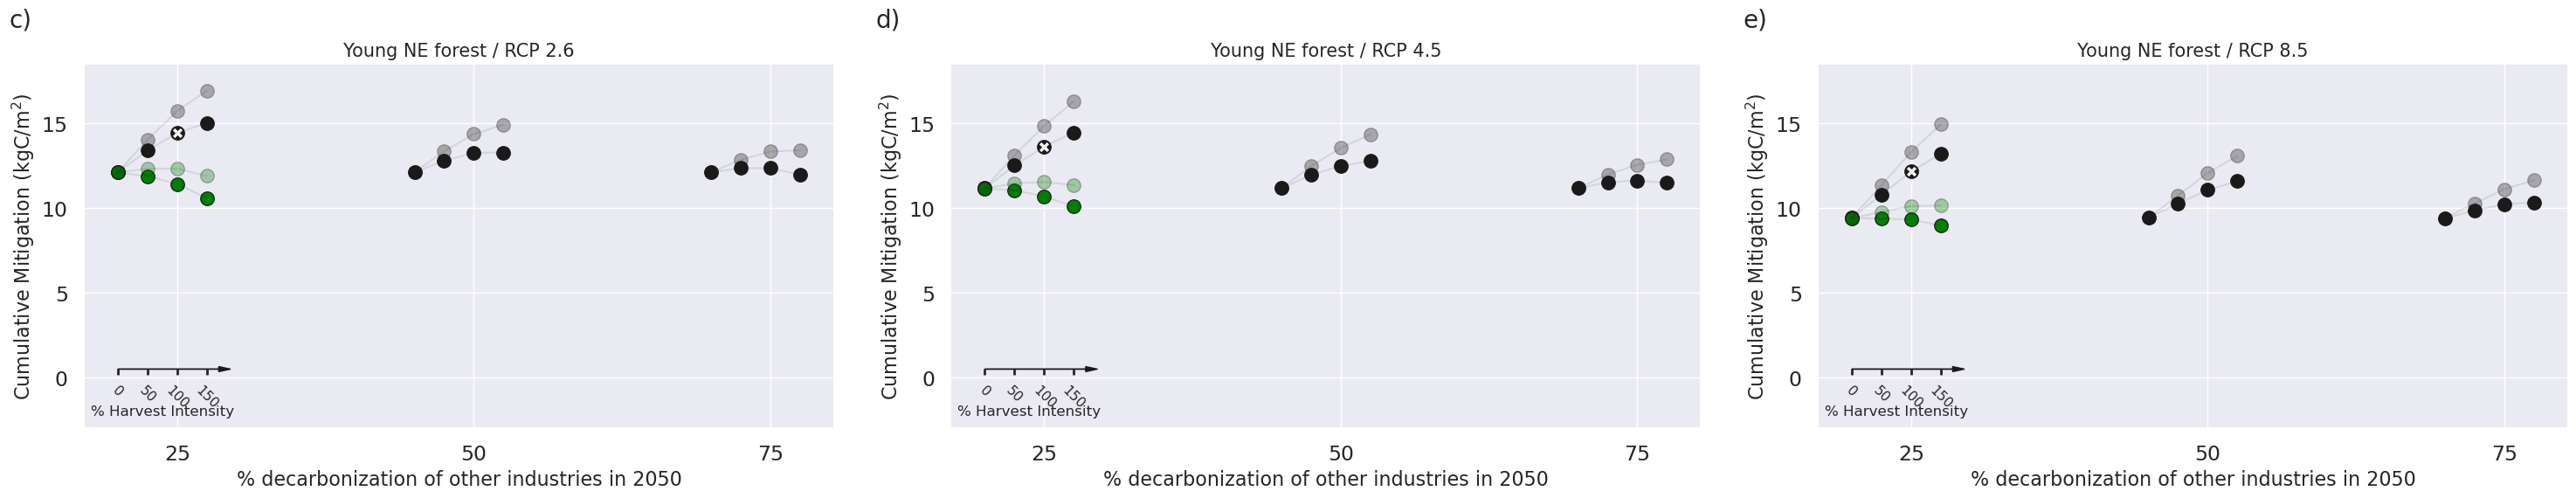

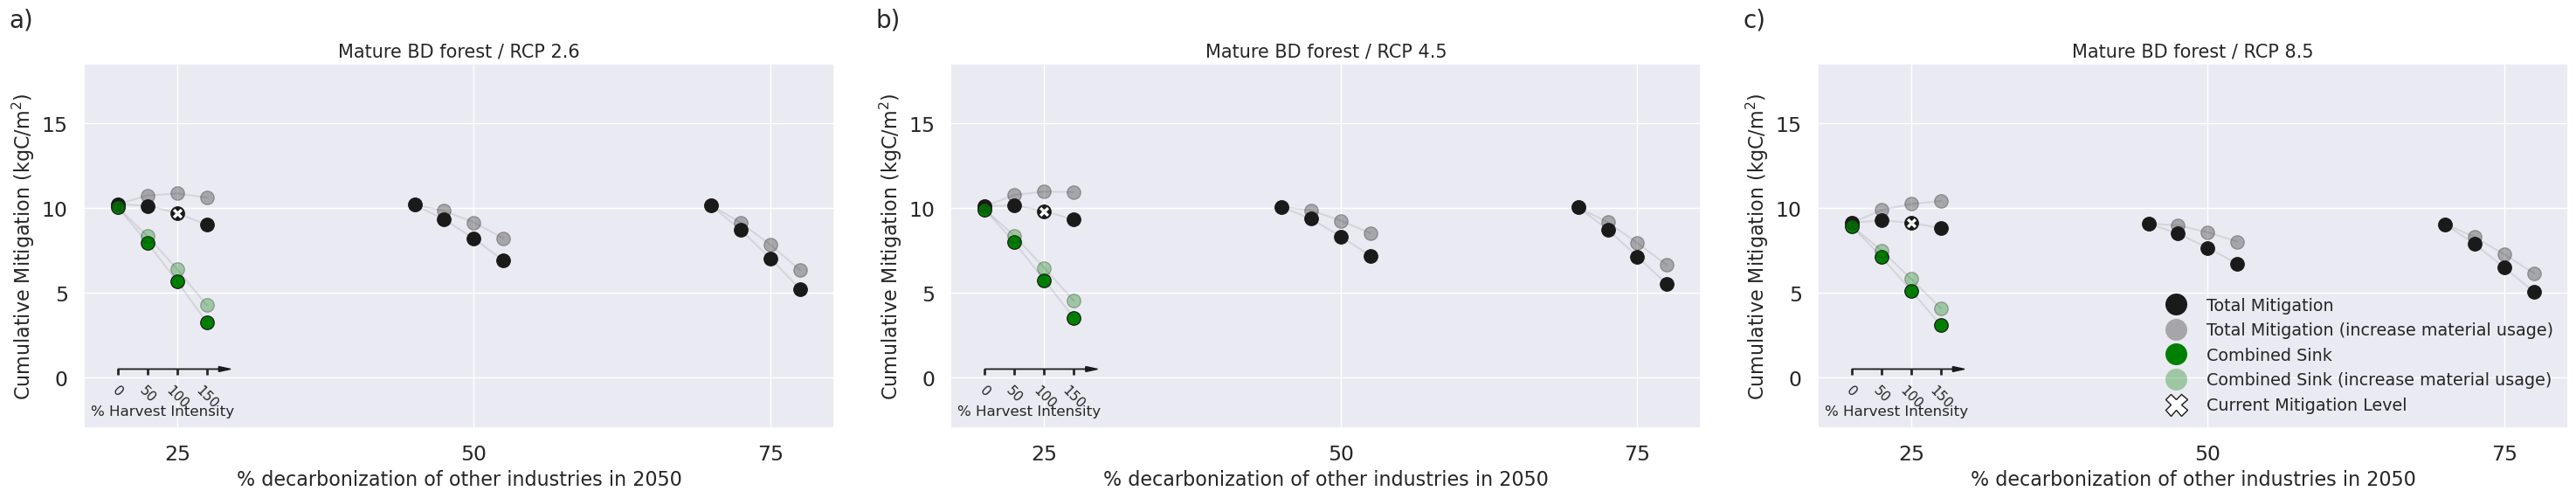

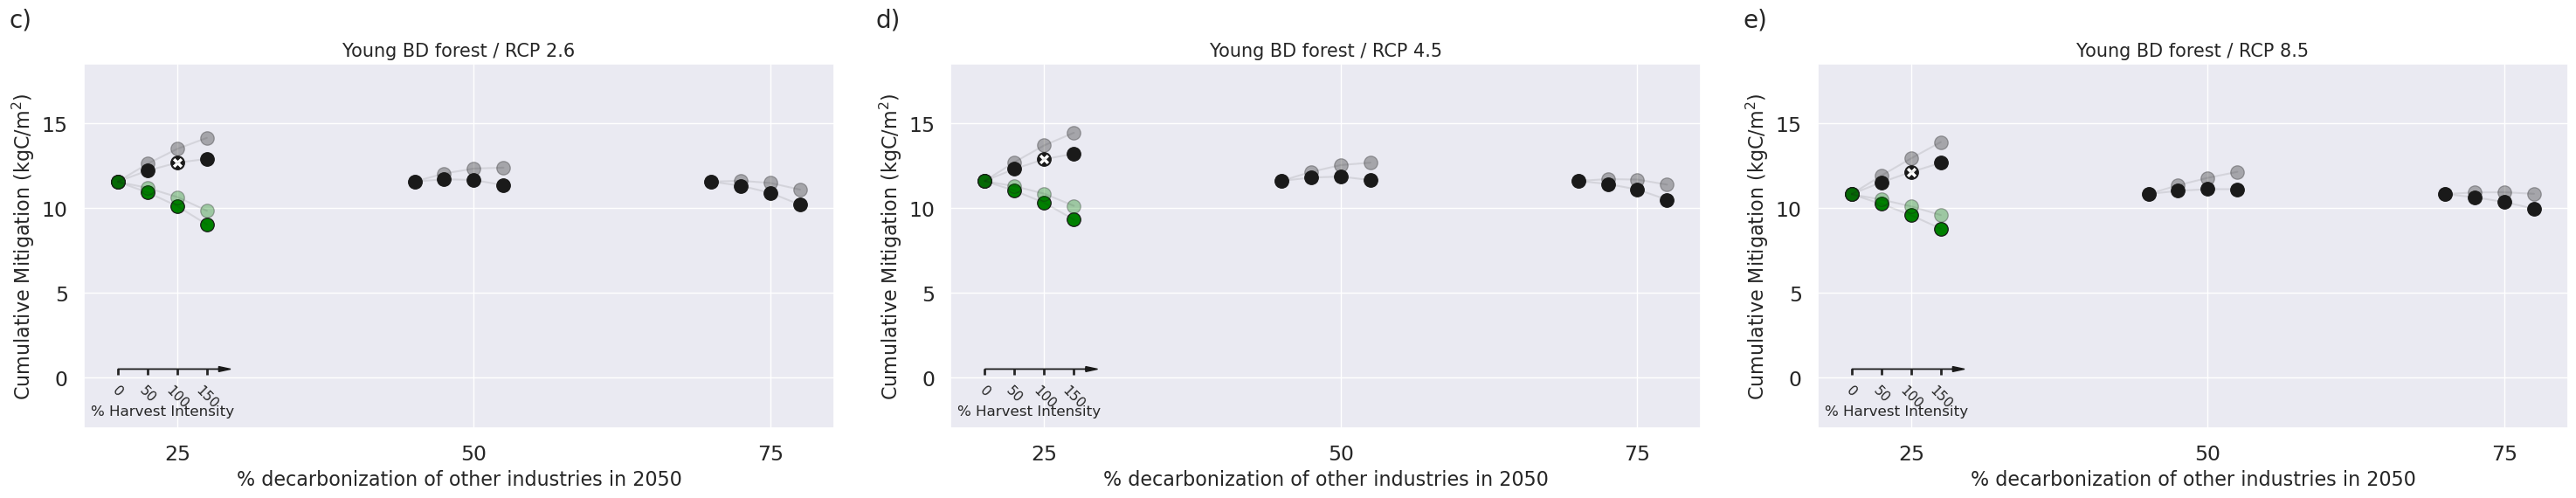

In [33]:
subs_analysis_functions.plot_substitution_analysis(forest_type='ne', subs_data=subs_data_global_01_50_patches_full_decarb, ylims=[-3, 18.5])
subs_analysis_functions.plot_substitution_analysis(forest_type='bd', subs_data=subs_data_global_01_50_patches_full_decarb, ylims=[-3, 18.5])